In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d snap/amazon-fine-food-reviews
!unzip amazon-fine-food-reviews.zip


Dataset URL: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
License(s): CC0-1.0
100% 241M/242M [00:11<00:00, 25.3MB/s]
100% 242M/242M [00:11<00:00, 21.8MB/s]
Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
from sklearn.model_selection import train_test_split

import nltk
import string
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords=set(stopwords.words('english'))

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
dataset = pd.read_csv("/content/Reviews.csv")
dataset.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
dataset.shape

(568454, 10)

In [7]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [8]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,568454.0,2.842275e+05,1.640987e+05,1.0,1.421142e+05,2.842275e+05,4.263408e+05,5.684540e+05
HelpfulnessNumerator,568454.0,1.743817e+00,7.636513e+00,0.0,0.000000e+00,0.000000e+00,2.000000e+00,8.660000e+02
HelpfulnessDenominator,568454.0,2.228810e+00,8.289740e+00,0.0,0.000000e+00,1.000000e+00,2.000000e+00,9.230000e+02
Score,568454.0,4.183199e+00,1.310436e+00,1.0,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
Time,568454.0,1.296257e+09,4.804331e+07,939340800.0,1.271290e+09,1.311120e+09,1.332720e+09,1.351210e+09


In [9]:
dataset.isnull().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,26
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


In [10]:
dataset[dataset.duplicated()].sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,0
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,0
Text,0


In [11]:
for col in dataset:
  print(col,": " ,dataset[col].nunique())

Id :  568454
ProductId :  74258
UserId :  256059
ProfileName :  218415
HelpfulnessNumerator :  231
HelpfulnessDenominator :  234
Score :  5
Time :  3168
Summary :  295742
Text :  393579


<Axes: xlabel='Score', ylabel='count'>

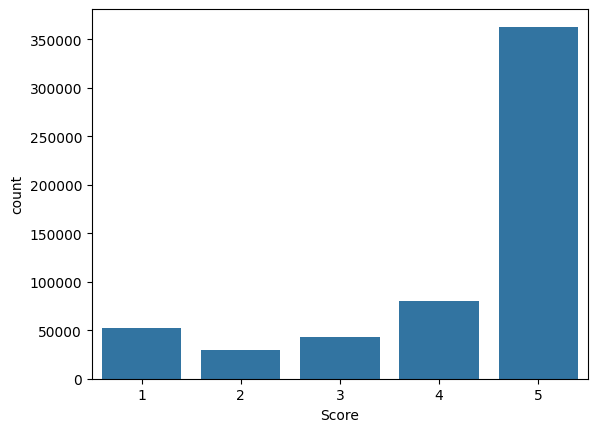

In [12]:
sns.countplot(data=dataset,x="Score")

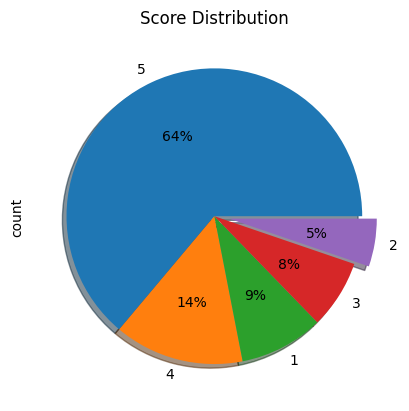

In [13]:
dataset['Score'].value_counts().plot(kind='pie',explode=(0,0,0,0,0.1),shadow=True,autopct="%.0f%%")
plt.title('Score Distribution')
plt.show()

In [14]:
dataset.iloc[0].Text

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [15]:
text = dataset["Text"].values
text

array(['I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.',
       'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".',
       'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.',
    

### Text Cleaning:

In [16]:
def clean(text):
    text=str(text).lower()
     # Remove text within square brackets
    text=re.sub('\[.*?\]','',text)
    # Remove URLs
    text=re.sub('https?://\S+|www\.\S+','',text)
    # Remove HTML tags
    text = re.sub('<.*?>+', '', text)
    #  Removing Punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Replace newline characters with spaces
    text = re.sub('\n', '', text)
    # Remove words containing digits
    text = re.sub('\w*\d\w*', '', text)
     # Tokenize the text and remove stopwords
    text = [word for word in text.split(' ') if word not in stopwords]
    text=" ".join(text)
    # Stem the remaining words
    text = [stemmer.stem(word) for word in text.split(' ')]
    # Join the cleaned and stemmed words back into a string
    text=" ".join(text)
    return text

In [17]:
dataset.shape

(568454, 10)

In [18]:
pos_neg_data = dataset[dataset['Score']!=3]
print(pos_neg_data.shape)
pos_neg_data.head(5)

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [19]:
def sentiment(score):

    if score > 3:
        return 'Positive'
    elif score < 3:
        return 'Negative'
    else:
        return 'Neutral'

# Extracting scores from pos_neg_data
score_updt = pos_neg_data['Score']

# Applying partition function to each score
scor_map = score_updt.apply(sentiment)

# Updating 'Score' column in pos_neg_data with the mapped values
pos_neg_data['Score'] = scor_map

In [20]:
pos_neg_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [21]:
final_data= pos_neg_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'})
print(final_data.shape)
final_data.head()

(364173, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [22]:
final = final_data[final_data['HelpfulnessNumerator']<=final_data['HelpfulnessDenominator']]
final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,Positive,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,Negative,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,Positive,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,Positive,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [23]:
data_cleaned=pd.DataFrame()
data_cleaned['Text']=final["Text"].apply(clean)
data_cleaned['Score']=final['Score']
data_cleaned

,Text,Score
0,bought sever vital can dog food product found ...,Positive
1,product arriv label jumbo salt peanutsth peanu...,Negative
2,confect around centuri light pillowi citrus g...,Positive
3,look secret ingredi robitussin believ found g...,Negative
4,great taffi great price wide assort yummi taf...,Positive
...,...,...
568449,great sesam chickenthi good better restur eate...,Positive
568450,im disappoint flavor chocol note especi weak m...,Negative
568451,star small give one train session tri train ...,Positive
568452,best treat train reward dog good groom lower ...,Positive


In [24]:
corpus=''.join(i for i in data_cleaned['Text'])

In [25]:
text=data_cleaned['Text'].values
text

array(['bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better ',
       'product arriv label jumbo salt peanutsth peanut actual small size unsalt sure error vendor intend repres product jumbo',
       'confect around centuri  light pillowi citrus gelatin nut  case filbert cut tini squar liber coat powder sugar  tini mouth heaven  chewi flavor  high recommend yummi treat  familiar stori cs lewi lion witch wardrob  treat seduc edmund sell brother sister witch',
       ...,
       'star small give  one train session  tri train dog ceaser dog treat  made puppi hyper  compar ingredi know  littl star basic food ingredi without preserv food color  sweet potato flavor also make hand smell like dog food',
       'best treat train reward dog good groom  lower calori love doggi  sweet potato seem favorit wet nose treat',
       'satisfi product advertis use cereal raw vinegar general sweetner'],
      dt

In [26]:
# Step 1: Tokenization
tokens = []
for sentence in text:
    tokens.extend(sentence.split())

In [27]:
# Step 2: Frequency Count
word_count = {}
for token in tokens:
    if token in word_count:
        word_count[token] += 1
    else:
        word_count[token] = 1

In [28]:
word_count

{'bought': 32007,
 'sever': 14079,
 'vital': 334,
 'can': 13763,
 'dog': 48953,
 'food': 75135,
 'product': 116423,
 'found': 35216,
 'good': 124845,
 'qualiti': 21503,
 'look': 38089,
 'like': 170513,
 'stew': 1199,
 'process': 5647,
 'meat': 8727,
 'smell': 19903,
 'better': 42522,
 'labrador': 201,
 'finicki': 910,
 'appreci': 3021,
 'arriv': 14842,
 'label': 6794,
 'jumbo': 236,
 'salt': 17618,
 'peanutsth': 11,
 'peanut': 13756,
 'actual': 18807,
 'small': 19912,
 'size': 18639,
 'unsalt': 396,
 'sure': 19590,
 'error': 531,
 'vendor': 2146,
 'intend': 1325,
 'repres': 465,
 'confect': 223,
 'around': 14213,
 'centuri': 242,
 'light': 12777,
 'pillowi': 9,
 'citrus': 1121,
 'gelatin': 790,
 'nut': 10570,
 'case': 13175,
 'filbert': 34,
 'cut': 7450,
 'tini': 3708,
 'squar': 1801,
 'liber': 214,
 'coat': 5217,
 'powder': 11599,
 'sugar': 37104,
 'mouth': 7755,
 'heaven': 2068,
 'chewi': 5277,
 'flavor': 125750,
 'high': 32108,
 'recommend': 37737,
 'yummi': 6817,
 'treat': 31787,
 

In [29]:
# creating a data frame for understanding word frequency
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data_cleaned['Text'])

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x:x[1], reverse=True)

frequency = pd.DataFrame(words_freq, columns=['word', 'count'])
frequency.head(10)

,word,count
0,like,170513
1,tast,160270
2,flavor,125750
3,good,124845
4,use,118124
5,product,116423
6,love,115071
7,great,107160
8,tri,102773
9,tea,92424


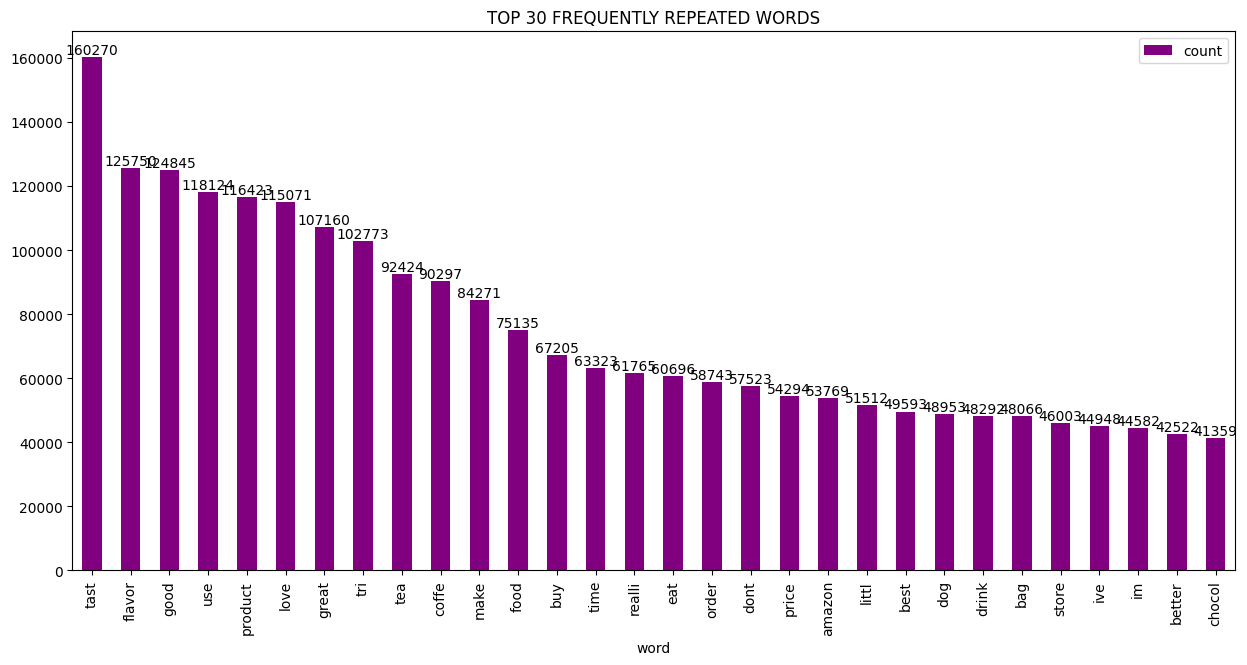

In [30]:
# plotting the word frequency
freq_plot = frequency.loc[1:30].plot(x='word', y='count', kind='bar', figsize=(15,7), color='purple')
freq_plot.bar_label(freq_plot.containers[0])
plt.title('TOP 30 FREQUENTLY REPEATED WORDS')
plt.show()

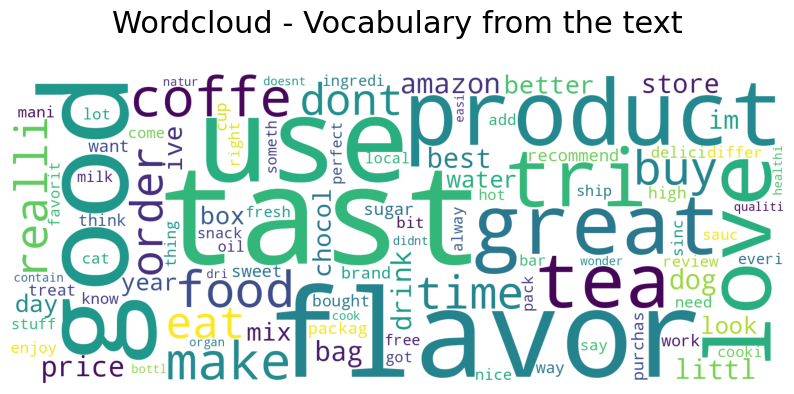

In [31]:
from wordcloud import WordCloud

wc_plot = WordCloud(background_color='white', width=1500, height=600).generate_from_frequencies(dict(words_freq[1:100]))

plt.figure(figsize=(10,8))
plt.imshow(wc_plot)
plt.title('Wordcloud - Vocabulary from the text\n', fontsize=22)
plt.axis('off')
plt.show()

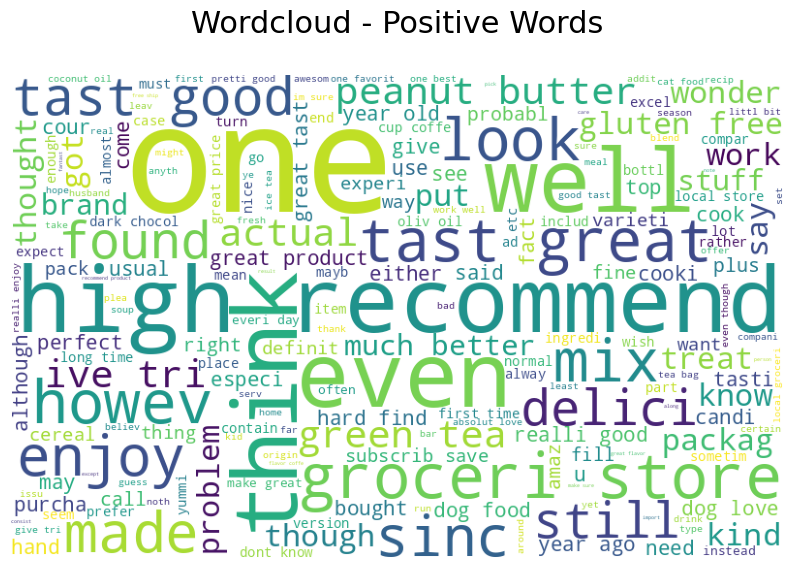

In [32]:
# wordcloud for positive words
postive_tweets = ' '.join([word for word in data_cleaned['Text'][data_cleaned["Score"]=="Positive"]])

items_to_remove = ['user', 'ð']
pattern = r'\b(' +'|'.join(re.escape(word) for word in items_to_remove) + r')\b'
res = re.sub(pattern, "", postive_tweets)
res = re.sub(r'\s+', " ", res).strip()

pwc_plot = WordCloud(background_color='white', width=800, height=500).generate(res)

plt.figure(figsize=(10,8))
plt.imshow(pwc_plot)
plt.title('Wordcloud - Positive Words\n', fontsize=22)
plt.axis('off')
plt.show()

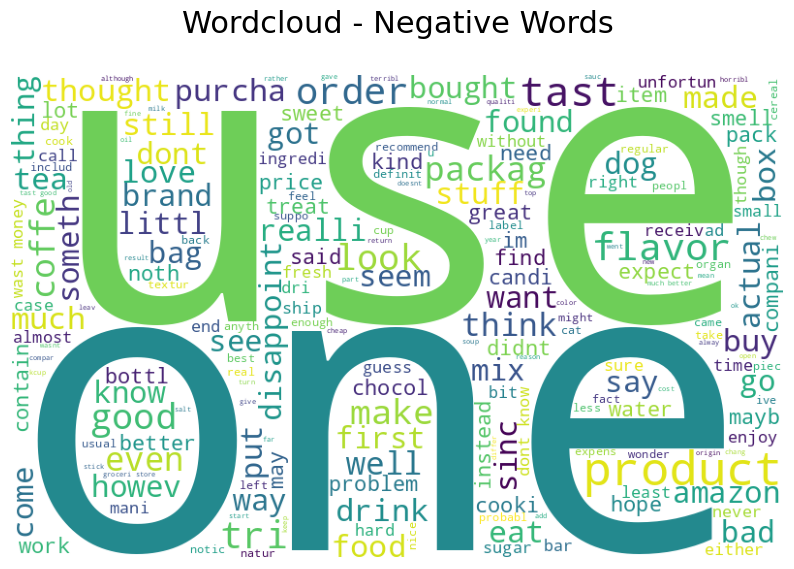

In [33]:
# wordcloud for negative words
postive_tweets = ' '.join([word for word in data_cleaned['Text'][data_cleaned["Score"]=="Negative"]])

items_to_remove = ['user', 'ð']
pattern = r'\b(' +'|'.join(re.escape(word) for word in items_to_remove) + r')\b'
res = re.sub(pattern, "", postive_tweets)
res = re.sub(r'\s+', " ", res).strip()

pwc_plot = WordCloud(background_color='white', width=800, height=500).generate(res)

plt.figure(figsize=(10,8))
plt.imshow(pwc_plot)
plt.title('Wordcloud - Negative Words\n', fontsize=22)
plt.axis('off')
plt.show()

In [34]:

data_cleaned

,Text,Score
0,bought sever vital can dog food product found ...,Positive
1,product arriv label jumbo salt peanutsth peanu...,Negative
2,confect around centuri light pillowi citrus g...,Positive
3,look secret ingredi robitussin believ found g...,Negative
4,great taffi great price wide assort yummi taf...,Positive
...,...,...
568449,great sesam chickenthi good better restur eate...,Positive
568450,im disappoint flavor chocol note especi weak m...,Negative
568451,star small give one train session tri train ...,Positive
568452,best treat train reward dog good groom lower ...,Positive


In [35]:
data_cleaned["Score"].value_counts()

,count
Score,
Positive,307061
Negative,57110


In [36]:
# Tokenization: converting words or subwords into numerical tokens
max_features=5000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(text)
# tokenizes the input text data into sequences of integer indices
sequences = tokenizer.texts_to_sequences(text)

In [37]:
x=sequences
x= pad_sequences(x)
x

array([[   0,    0,    0, ...,  817,    6,   39],
       [   0,    0,    0, ..., 2585,    6, 3731],
       [   0,    0,    0, ...,  358, 1509, 1186],
       ...,
       [   0,    0,    0, ...,    1,   31,   15],
       [   0,    0,    0, ...,  894, 1251,   64],
       [   0,    0,    0, ...,  820,  639, 1728]], dtype=int32)

In [38]:
x.shape

(364171, 1232)

In [39]:
vocab_size = len(word_count)
print("Vocabulary size:", vocab_size)

Vocabulary size: 243504


In [40]:
model = Sequential([
    tf.keras.layers.Embedding(vocab_size, output_dim=50),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [41]:
y=pd.get_dummies(data_cleaned['Score']).values
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size = 0.33, random_state = 42)

In [42]:
import tensorflow as tf
early_stopping=tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0.0001,
                patience=20,
                verbose=1,
                mode='auto',
                baseline=None,
                restore_best_weights=False,
                )
model.fit(X_train, Y_train,epochs = 15,batch_size=100,verbose = 2)

Epoch 1/15
2440/2440 - 127s - 52ms/step - accuracy: 0.9140 - loss: 0.2166
Epoch 2/15
2440/2440 - 138s - 57ms/step - accuracy: 0.9302 - loss: 0.1770
Epoch 3/15
2440/2440 - 142s - 58ms/step - accuracy: 0.9373 - loss: 0.1593
Epoch 4/15
2440/2440 - 142s - 58ms/step - accuracy: 0.9431 - loss: 0.1450
Epoch 5/15
2440/2440 - 142s - 58ms/step - accuracy: 0.9480 - loss: 0.1331
Epoch 6/15
2440/2440 - 141s - 58ms/step - accuracy: 0.9537 - loss: 0.1208
Epoch 7/15
2440/2440 - 143s - 58ms/step - accuracy: 0.9580 - loss: 0.1098
Epoch 8/15
2440/2440 - 121s - 50ms/step - accuracy: 0.9596 - loss: 0.1055
Epoch 9/15
2440/2440 - 122s - 50ms/step - accuracy: 0.9664 - loss: 0.0891
Epoch 10/15
2440/2440 - 142s - 58ms/step - accuracy: 0.9696 - loss: 0.0814
Epoch 11/15
2440/2440 - 142s - 58ms/step - accuracy: 0.9733 - loss: 0.0730
Epoch 12/15
2440/2440 - 142s - 58ms/step - accuracy: 0.9762 - loss: 0.0656
Epoch 13/15
2440/2440 - 122s - 50ms/step - accuracy: 0.9780 - loss: 0.0607
Epoch 14/15
2440/2440 - 122s - 50m

In [43]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

3756/3756 ━━━━━━━━━━━━━━━━━━━━ 71s 19ms/step - accuracy: 0.9161 - loss: 0.3494
Test Loss: 0.3513036370277405
Test Accuracy: 0.9168559908866882


In [44]:
# Sample review text
new_review = "This product is amazing! I love it."

In [45]:
# Tokenize the review text
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts([new_review])
sequences = tokenizer.texts_to_sequences([new_review])

# Pad sequences to have the same length as your model's input
max_sequence_length = 100  # Adjust this according to your model's input length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Now, padded_sequences contains the numerical representation of your review text

In [46]:
# Assuming your model is already trained and stored in 'model'
predictions = model.predict(padded_sequences)

# Assuming your model predicts probabilities for each class, you can get the predicted class
predicted_class = np.argmax(predictions)

# You can also get the probability score for each class
probability_scores = predictions[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


In [47]:
# Assuming you have a mapping of class indices to class labels
class_labels = {0: 'Negative', 1: 'Positive'}

# Get the predicted label
predicted_label = class_labels[predicted_class]

In [48]:
print("Predicted Label:", predicted_label)
print("Probability Scores:", probability_scores)

Predicted Label: Positive
Probability Scores: [0.0283158 0.9716842]


## Conclusion and Results

In this project, I performed sentiment analysis on the Amazon Fine Food Reviews dataset using an LSTM neural network. The key steps involved were:

1. **Data Preparation and Cleaning:**
   - Imported necessary libraries and modules for data processing, text cleaning, and building the neural network.
   - Cleaned the text data by removing URLs, HTML tags, punctuation, newline characters, and words containing digits. Tokenized the text and removed stopwords.
   - Stemmed the remaining words for normalization.

2. **Tokenization:**
   - Utilized the `Tokenizer` class from TensorFlow to convert the text data into sequences of integer indices, a common preprocessing step for neural networks.
   - Set the maximum number of features (vocabulary size) to 5000 to limit the number of unique words considered.

3. **Padding:**
   - Applied padding to ensure that all sequences have the same length, which is necessary for training LSTM models.

4. **Model Architecture:**
   - Defined a Sequential model with the following layers:
     - An Embedding layer to convert word indices to dense vectors of fixed size.
     - An LSTM layer with 50 units to capture temporal dependencies in the data.
     - A Dense output layer with a softmax activation function for binary classification.
   - Compiled the model using categorical cross-entropy loss and the Adam optimizer.

5. **Model Training and Evaluation:**
   - The model was trained on the preprocessed and tokenized text data.
   - Evaluation metrics  as accuracy and F1-score were used to measure the model's performance.
   
The model achieved an accuracy of `92%`.

In [49]:

# mapping = {"Positive": 1, "Negative": 0}
# data_cleaned['Score'] = data_cleaned['Score'].map(mapping)

In [50]:
# data_cleaned

In [51]:
# preprocessed_rewviews = data_cleaned["Text"].values

In [52]:
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [53]:
# tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
# tfidf_vect.fit(preprocessed_rewviews)
# print("Some Feature name", tfidf_vect.get_feature_names_out()[1500:1550])

# print("="*50)

# tfidf_vect_counts = tfidf_vect.transform(preprocessed_rewviews)
# print("The type of tfidf vectorizer :", type(tfidf_vect_counts))
# print("The shape of the tfidf :", tfidf_vect_counts.get_shape())
# print("The number of unique words", tfidf_vect_counts.get_shape()[1])

In [54]:
# x = pd.DataFrame(tfidf_vect_counts.toarray())


In [55]:
# x.shape

In [56]:
# y = data_cleaned  ['Score']
# y.shape

In [57]:
# # data splitting
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# print(x_train.shape)
# print(x_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [58]:
# # data standardization
# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()

# x_train = sc.fit_transform(x_train)
# x_test = sc.transform(x_test)

In [59]:
# # ML based NLP model
# # Randomforest

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, f1_score

# rf_model = RandomForestClassifier()
# rf_model.fit(x_train, y_train)

# y_pred = rf_model.predict(x_test)

# # evaluation
# print('Test Accuracy:', accuracy_score(y_test, y_pred))
# print('F1-Score:', f1_score(y_test, y_pred))
# cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)